<p style='text-align:center'>
PSY 394U <b>Methods for fMRI</b>, Fall 2019


<img style='width: 300px; padding: 0px;' src='https://github.com/sathayas/JupyterfMRIFall2019/blob/master/Images/Placebo_Left.png?raw=true' alt='brain blobs'/>

</p>

<p style='text-align:center; font-size:40px; margin-bottom: 30px;'><b> First-level analysis </b></p>

<p style='text-align:center; font-size:18px; margin-bottom: 32px;'><b> October 14, 2019</b></p>

<hr style='height:5px;border:none' />

# Finger-foot-lips task data
<hr style="height:1px;border:none" />

For this demonstration, we will use the test-retest data (i.e., ds114 data). Among all the fMRI data, we will focus on the **finger foot lips** task data. In brief, during this experiment, subjects were instructed to move body parts shown on the screen. In particular, they tapped fingers on the dominant hand (**hand**), flexed the dominant foot (**foot**), and pursed lips (**lips**). 

All subjects underwent the same study paradigm, for both test and re-test sessions. We can see details on the experiment from the task event data for this paradigm. 

[`<TaskInfo_fingerfootlips.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/TaskInfo_fingerfootlips.py)

In [1]:
import os
import json
import pandas as pd
from bids.layout import BIDSLayout

# Directory where your data set resides.
dataDir = '/tmp/Data/ds114'

# Creating the layout objects
layout = BIDSLayout(dataDir)


# Task events tsv file for fingerfootlips, all subjects, both sessions
taskTSV = layout.get(task='fingerfootlips',
                     suffix='events',
                     extension='tsv',
                     return_type='file')[0]

# reading the task info (as pandas data frame)
taskInfo = pd.read_csv(taskTSV, delimiter='\t')

# see whats in the task info
print(taskInfo)


    onset  duration  weight trial_type
0      10      15.0       1     Finger
1      40      15.0       1       Foot
2      70      15.0       1       Lips
3     100      15.0       1     Finger
4     130      15.0       1       Foot
5     160      15.0       1       Lips
6     190      15.0       1     Finger
7     220      15.0       1       Foot
8     250      15.0       1       Lips
9     280      15.0       1     Finger
10    310      15.0       1       Foot
11    340      15.0       1       Lips
12    370      15.0       1     Finger
13    400      15.0       1       Foot
14    430      15.0       1       Lips


As you see, the three conditions were presented in a pattern of Finger-Foot-Lips, with each condition lasting for 15s. The onset times are regularly spaced, as you can see.

We can also take a look at the accompanying JSON file for any meta data associated with this paradigm.

In [4]:
# Other meta info from accompanying JSON file
taskJSON = layout.get(task='fingerfootlips',
                      suffix='bold',
                      extension='json',
                      return_type='file')[0]

# reading the JSON file
f = open(taskJSON,'r')
taskDict = json.load(f)
f.close()

# contents of the JSON file
for iKey, iValue in taskDict.items():
    print(iKey + ':   ' + str(iValue))

EchoTime:   0.05
SliceTiming:   [0.0, 1.2499999999999998, 0.08333333333333333, 1.333333333333333, 0.16666666666666666, 1.4166666666666663, 0.25, 1.4999999999999996, 0.3333333333333333, 1.5833333333333328, 0.41666666666666663, 1.666666666666666, 0.5, 1.7499999999999993, 0.5833333333333333, 1.8333333333333326, 0.6666666666666666, 1.9166666666666659, 0.75, 1.9999999999999991, 0.8333333333333333, 2.083333333333332, 0.9166666666666666, 2.1666666666666656, 1.0, 2.249999999999999, 1.0833333333333333, 2.333333333333332, 1.1666666666666665, 2.416666666666665]
FlipAngle:   90
RepetitionTime:   2.5
TaskName:   finger_foot_lips


You can get TR from this file (2.5s in this case), as well as the slice timing information.

# First-level analysis - single subject
<hr style="height:1px;border:none" />

## Pre-processed data

Now let us perform a first-level analysis on one of the subjects (`sub-09`). We will focus on the test session (`ses-test`). We shall use the pre-processed data by fMRIprep. If you haven't done already, you can download the tar ball of the pre-processed data from [here](https://utexas.box.com/s/88zh69bgncqda2vrf2vg0nu2ecuaw1ld). After downloading the file, put the `.tar.gz` file under the `ds114` directory of your data directory. To uncompress and unpack the data, you need to run, on your terminal (from your docker),
```
gunzip ds114_derivatives_selected.tar.gz
```
Then expand the tar ball by
```
tar -xvf ds114_derivatives_selected.tar
```
This should create a directory called **`derivatives_selected`** under `ds114` directory.


## Some pre-processing steps

The fMRI data processed with fMRIprep is normalized in the MNI space. Unfortunately fMRIprep does not perform certain pre-processing steps necessary for the first-level analysis. So we will include some pre-processing nodes in our first-level analysis script.

[`<Level1_ds114_fingerfootlips_sub-09.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/Level1_ds114_fingerfootlips_sub-09.py)

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import nibabel as nib   # nibabel to read TR from image header
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms import modelgen  # GLM model generator
from nipype.interfaces.base import Bunch
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)

##### DIRECTORY BUSINESS ######
# original data directory
dataDir = '/tmp/Data/ds114'
# Output directory
outDir = os.path.join(dataDir,'WorkflowOutput')


##### PARAMETERS TO BE USED #####
nDelfMRI = 4  # number of first scans to be deleted

First, we import necessary libraries, and defined the data directory and the output directory. We also specify a parameter for the number of first fMRI time points to be deleted (**`nDelfMRI`**) as 4.

Since the pre-processed fMRI data does not reside in a BIDS-compliant directory, we have to specify the paths to the fMRI data as well as the accompanying mask image.

In [3]:
###########
#
# SPECIFYING THE FMRI DATA AND OTHER IMAGE FILES
#
###########

# directory where preprocessed fMRI data is located
baseDir = os.path.join(dataDir, 'derivatives_selected/fmriprep')
subjDir = os.path.join(baseDir, 'sub-09')
sesDir = os.path.join(subjDir, 'ses-test/func')

# location of the pre-processed fMRI & mask
# NB: Assuming that the preprocessing is done with fMRIprep
fList = os.listdir(sesDir)  # getting the directory contents
imagefMRI = [x for x in fList if
                ('task-fingerfootlips' in x) and   # fingerfootlips task
                ('preproc_bold.nii.gz' in x)][0]   # identifying the bold data
imageMask = [x for x in fList if
                ('task-fingerfootlips' in x) and   # fingerfootlips task
                ('brain_mask.nii.gz' in x)][0]   # identifying the bold data

filefMRI = os.path.join(sesDir,imagefMRI)
fileMask = os.path.join(sesDir,imageMask)

* `filefMRI`: full path to the fMRI data image file
* `fileMask`: full path to the mask image file

Now, first item of post-pre-processing steps is to delete first time points from the fMRI data.

In [4]:
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=filefMRI,  # input image full path
                              t_min=nDelfMRI,    # first volumes to be deleted
                              t_size=-1),
               name="extract")


Next, smoothing fMRI data with SUSAn.

In [5]:
# smoothing with SUSAN
susan = Node(fsl.SUSAN(brightness_threshold = 2000.0,  
                       fwhm=6.0),    # smoothing filter width (6mm, isotropic)
             name='susan')


And masking with the brain mask -- so that non-brain voxels won't be included in the analysis.

In [6]:
# masking the fMRI with a brain mask
applymask = Node(fsl.ApplyMask(mask_file=fileMask),
                 name='applymask')


## Reading and organizing the task event data

To use the task event information in the first level analysis, it needs to be organized in a certain way. First, we locate the task event data file.

In [7]:
# Creating the layout object for this BIDS data set
layout = BIDSLayout(dataDir)

# task information file
fileEvent = layout.get(suffix='events',
                       task='fingerfootlips',
                       extension='tsv',
                       return_type='file')[0]

TR is one of the necessary information setting up the first level model. You can read that information from the fMRI image header.

In [8]:
# getting TR from the image header
fMRI = nib.load(filefMRI)   # image object
hdr_fMRI = fMRI.header
TR = hdr_fMRI['pixdim'][4]

Since we have deleted a number of time points from the fMRI data, we need to adjust event onset time later. For that purpose, we calculate how many seconds the onset times need to be adjusted by multiplying TR with the number of deleted time points. This results in the offset for the onset time in terms of seconds.

In [9]:
onsetOffset = nDelfMRI * TR  # time adjustement due to deleted fMRI volumes

Now read the task event data, and get distinct conditions for this fMRI data.

In [10]:
trialInfo = pd.read_csv(fileEvent, sep='\t')
conditions = sorted(list(set(trialInfo.trial_type)))

In [11]:
conditions

['Finger', 'Foot', 'Lips']

Now, we extract onset times and stimulus durations for each of these conditions.

In [12]:
onsets = []
durations = []

for itrial in conditions:
    onsets.append(list(trialInfo[trialInfo.trial_type==itrial].onset-onsetOffset))
    durations.append(list(trialInfo[trialInfo.trial_type==itrial].duration))

Notice that the onset time is adjusted by the offset we calculated earlier. Now we have two nested lists for onset times and durations.

In [13]:
onsets

[[0.0, 90.0, 180.0, 270.0, 360.0],
 [30.0, 120.0, 210.0, 300.0, 390.0],
 [60.0, 150.0, 240.0, 330.0, 420.0]]

In [14]:
durations

[[15.0, 15.0, 15.0, 15.0, 15.0],
 [15.0, 15.0, 15.0, 15.0, 15.0],
 [15.0, 15.0, 15.0, 15.0, 15.0]]

Now the conditions, onset times, and durations are combined as an object known as a bunch.

In [15]:
subject_info = [Bunch(conditions=conditions,
                      onsets=onsets,
                      durations=durations,
                      )]

In [16]:
subject_info

[Bunch(conditions=['Finger', 'Foot', 'Lips'],
       durations=[[15.0, 15.0, 15.0, 15.0, 15.0],
        [15.0, 15.0, 15.0, 15.0, 15.0],
        [15.0, 15.0, 15.0, 15.0, 15.0]],
       onsets=[[0.0, 90.0, 180.0, 270.0, 360.0],
        [30.0, 120.0, 210.0, 300.0, 390.0],
        [60.0, 150.0, 240.0, 330.0, 420.0]])]

Now, we define contrasts we will examine later.

In [17]:
## Defining contrasts
cont01 = ['average',        'T', conditions, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', conditions, [1, 0, 0]]
cont03 = ['Foot',           'T', conditions, [0, 1, 0]]
cont04 = ['Lips',           'T', conditions, [0, 0, 1]]
cont05 = ['Finger > others','T', conditions, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', conditions, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', conditions, [-0.5, -0.5, 1]]

Each contrast is a list, as you can see. For a T contrast, these are required items:
  1. Contrast name
  2. Contrast type (`'T'` in this case, for a T-contrast)
  3. A list of conditions to be examined
  4. A vector of weights for that contrast

In [18]:
cont08 = ['activation',     'F', [cont02, cont03, cont04]]

As for an F contrast, we are examining any activation by an omnibus test of `cont02`, `cont03`, and `cont04`.

Finally, we create a list of contrasts.

In [19]:
contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08]

## Setting up the first-level analysis

Finally we can set up the actual first-level analysis. The first item is convert the experiment design into a form that can be used in subsequent steps. This is done by the **`SpecifyModel`** process available under **`nipype.algorithms.modelgen.SpecifyModel`**

In [20]:
# model specification
modelspec = Node(modelgen.SpecifyModel(subject_info=subject_info,
                                       input_units='secs',
                                       time_repetition=TR,
                                       high_pass_filter_cutoff=100),
                 name="modelspec")

Now we generate actual regressors based on the experiment design. The regressors are convolved with the HRF, and the corresponding derivative terms are also generated. This is done by the **`Level1Design`** available under **`nipype.interfaces.fsl`**.

In [21]:
# first-level design
level1design = Node(fsl.Level1Design(bases={'dgamma':{'derivs': True}},
                                     interscan_interval=TR,
                                     model_serial_correlations=True,
                                     contrasts=contrast_list),
                    name="level1design")


At this point, we generate additional necessary files to run the first-level analysis on **FEAT** in FSL, by the **`FEATModel`** process available under `nipype.interfaces.fsl`.

In [22]:
# creating all the other files necessary to run the model
modelgen = Node(fsl.FEATModel(),
                name='modelgen')

Finally, a node to run FEAT (appropriately named **`FEAT`** under `nipype.interfaces.fsl`).

In [23]:
# then running through FEAT
feat = Node(fsl.FEAT(),
            name="feat")


We also generate a datasink to collect some outputs.

In [24]:
# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir),
                name='datasink')


## Setting up the workflow

Now we have all the necessary nodes, we connect them into a workflow named **`firstLevel`**. Rather than explaining every connection, I just show you the code, as well as the diagram for the workflow.

In [25]:
# creating the workflow
firstLevel = Workflow(name="Level1_FingerFootLips", base_dir=outDir)

# connecting nodes
firstLevel.connect(extract, 'roi_file', susan, 'in_file')
firstLevel.connect(susan, 'smoothed_file', applymask, 'in_file')
firstLevel.connect(applymask, 'out_file', modelspec, 'functional_runs')
firstLevel.connect(modelspec, 'session_info', level1design, 'session_info')
firstLevel.connect(level1design, 'fsf_files', modelgen, 'fsf_file')
firstLevel.connect(level1design, 'ev_files', modelgen, 'ev_files')
firstLevel.connect(level1design, 'fsf_files', feat, 'fsf_file')
firstLevel.connect(feat, 'feat_dir', datasink, 'feat_dir')
firstLevel.connect(applymask, 'out_file', datasink, 'Level1_out_file')

190927-20:53:08,227 nipype.workflow INFO:
	 Generated workflow graph: /tmp/Data/ds114/WorkflowOutput/Level1_FingerFootLips/graph_orig.png (graph2use=orig, simple_form=True).


(-0.5, 450.5, 634.5, -0.5)

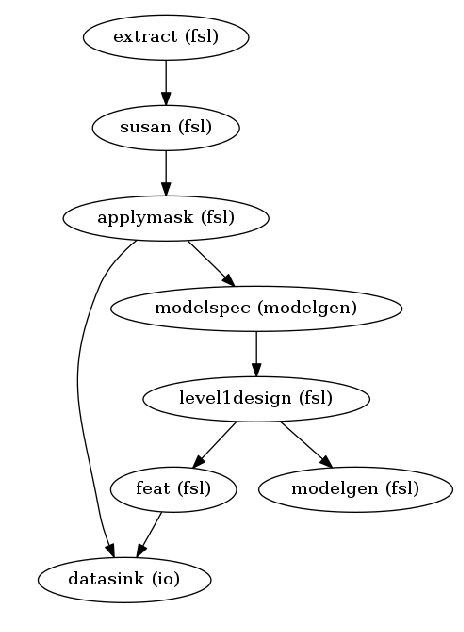

In [26]:
# writing out graphs
firstLevel.write_graph(graph2use='orig', dotfilename='graph_orig.dot')

# showing the graph
plt.figure(figsize=[11,11])
img=mpimg.imread(os.path.join(outDir,"Level1_FingerFootLips","graph_orig.png"))
imgplot = plt.imshow(img)
plt.axis('off')

Now we can run the first-level analysis, the whole thing. It may take 5-10 minutes, depending on your computer.

In [27]:
# running the workflow
firstLevel.run()


190927-20:53:11,95 nipype.workflow INFO:
	 Workflow Level1_FingerFootLips settings: ['check', 'execution', 'logging', 'monitoring']
190927-20:53:11,126 nipype.workflow INFO:
	 Running serially.
190927-20:53:11,130 nipype.workflow INFO:
	 [Node] Setting-up "Level1_FingerFootLips.extract" in "/tmp/Data/ds114/WorkflowOutput/Level1_FingerFootLips/extract".
190927-20:53:11,153 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /tmp/Data/ds114/derivatives_selected/fmriprep/sub-09/ses-test/func/sub-09_ses-test_task-fingerfootlips_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz /tmp/Data/ds114/WorkflowOutput/Level1_FingerFootLips/extract/sub-09_ses-test_task-fingerfootlips_space-MNI152NLin2009cAsym_desc-preproc_bold_roi.nii.gz 4 -1
190927-20:53:17,531 nipype.workflow INFO:
	 [Node] Finished "Level1_FingerFootLips.extract".
190927-20:53:17,535 nipype.workflow INFO:
	 [Node] Setting-up "Level1_FingerFootLip

# Examining the results
<hr style="height:1px;border:none" />

To examine the results from your first-level analysis, the easiest thing to do is to examine the analysis report generated by FSL. It should be located under the directory **`run0.feat`**, inside the **`feat_dir`** directory generated from the datasink. Under `run0.feat` directory, you can find **`report.html`**. This can be opened on a web browser.

## Stats
Under **`Stats`**, you can see the design matrix, consisting of the regressors for the three conditions, as well as their temporal derivatives. The regressors are convolved by HRF, as you can see. It also shows weights for different conditions for different contrasts.

## Post-stats

Show significant activations as blobs overlaid on the fMRI data, for different conditions.

## Visualization

You can also visualize the statistic image at a desired coordinate. For example, we will try the Z-statistic image for Contrast 6, Foot > others.

[`<ShowStatImage.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/ShowStatImage.py)

In [16]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, view_img
from nilearn.image import math_img, coord_transform

# Directory and file business
dataDir = '/tmp/Data/ds114'  # Data directory
anatDir = os.path.join(dataDir,'derivatives_selected/fmriprep/sub-09/anat/')
imageT1 = os.path.join(anatDir,
                       'sub-09_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')
featDir = os.path.join(dataDir,
                       'WorkflowOutput/feat_dir/run0.feat/')
statDir = os.path.join(featDir,'stats')
imageStat = os.path.join(statDir, 'zstat6.nii.gz')

We are only interested in activations, so we threshold the statistic image to include only positive statistics, using the **`math_img`** function as part of **`nilearn.image`**.

In [17]:
# thresholding the stat image to positive values only for visualization
thImageStat = math_img("np.ma.masked_less(img, 0)",
                                     img=imageStat)

Now we display the overlay of the Z-statistic image for this contrast at the maximum. We know the coordinate of the maximum in the voxel space (23, 27, 36), but it needs to be converted to the MNI space with the **`coord_transform`** function. We can generate the stat image overlay (on top of the corresponding T1-weighted image for the same subject) with the **`plot_stat_map`** function in **`nilearn.plotting`**. I shall not bore you with details about this function; interested students should consult the documentation for this function to figure out parameters.

In [18]:
# stat map at the maximum
plot_stat_map(thImageStat, bg_img=imageT1,
              colorbar=True, threshold=2.3, black_bg=True,
              draw_cross=True,
              cut_coords=coord_transform(23,27,36,thImageStat.affine))

Finally, if you are interested in interactive visualization, you can do that using the **`view_img`** function as we saw earlier in the semester. We start out at the local maximum coordinate.

In [19]:
# interactive visualization
view_img(thImageStat, bg_img=imageT1, cmap='black_red',
         symmetric_cmap=False, annotate=True,
         colorbar=True, threshold=2.3, black_bg=True,
         cut_coords=coord_transform(23,27,36,thImageStat.affine))

# Application - flanker task data
<hr style="height:1px;border:none" />

As an exercise, we will perform a first-level analysis of a subject from the flanker task data (ds102). 

## Pre-processed data
For this exercise we shall use the pre-processed data by fMRIprep. If you haven't done already, you can download the tar ball of the pre-processed data from [here](https://utexas.box.com/s/w4ofuq7myifrjbztkub66exvojdtl356). After downloading the file, put the `.tar.gz` file under the `ds102` directory of your data directory. To uncompress and unpack the data, you need to run, on your terminal (from your docker),
```
gunzip ds102_derivatives_selected.tar.gz
```
Then expand the tar ball by
```
tar -xvf ds102_derivatives_selected.tar
```
This should create a directory called **`derivatives_selected`** under `ds102` directory.


## Flanker task information

Now we shall examine the task information associated with this experiment. To do so, please select a subject from this data set. Then please select a run (run-1 or run-2) from that subject. 

### Exercise
1. **Conditions**. Read the task event information for the subject and run of your choice. Use a `BIDSLayout` object to specify the file name to read the file. Identify the column with information on conditions (congruent and incongruent). Post the code as well as the answer on Canvas.
2. **TR**. Read the task meta data from the appropriate JSON file. Use a `BIDSLayout` object to specify the file name to read the file. What is the TR in this experiment? Post the code as well as the answer on Canvas.

## Image data files

Now, let's get started coding the first-level analysis script. I suggest modifying (a.k.a., ***hacking***) my script for the first-level analysis of ds114 data set.

[`<Level1_ds102_SingleSubj.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/Level1_ds102_SingleSubj.py)

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import nibabel as nib   # nibabel to read TR from image header
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms import modelgen  # GLM model generator
from nipype.interfaces.base import Bunch
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)

##### DIRECTORY BUSINESS ######
# original data directory
dataDir = '/tmp/Data/ds102'
# Output directory
outDir = os.path.join(dataDir,'WorkflowOutput')


##### PARAMETERS TO BE USED #####
nDelfMRI = 4  # number of first scans to be deleted

### Exercise
**Specifying fMRI and mask images**. Now, we need to specify full paths to the pre-processed fMRI data (as **`filefMRI`**), as well as the accompanying brain mask (as **`fileMask`**). Unfortunately the directory generated by fMRIPrep does not follow the BIDS structure. Write a code to specify these (fill in the blank in the code). Post your code on Canvas.

## fMRI pre-processing steps

The fMRI pre-processing steps (skipping first few time points, smoothing, and masking) are the same as the ds114 analysis as you so saw before.

In [ ]:
# skip dummy scans
extract = Node(fsl.ExtractROI(in_file=filefMRI,  # input image full path
                              t_min=nDelfMRI,    # first volumes to be deleted
                              t_size=-1),
               name="extract")

# smoothing with SUSAN
susan = Node(fsl.SUSAN(brightness_threshold = 2000.0,
                       fwhm=6.0),    # smoothing filter width (6mm, isotropic)
             name='susan')

# masking the fMRI with a brain mask
applymask = Node(fsl.ApplyMask(mask_file=fileMask),
                 name='applymask')


## Reading and organizing the task event data

We first need to know the TR for this fMRI experiment. You can get this information from the fMRI meta data JSON file, or from the header of the fMRI data.

In [ ]:
# getting TR from the image header
fMRI = nib.load(filefMRI)   # image object
hdr_fMRI = fMRI.header
TR = hdr_fMRI['pixdim'][4]
onsetOffset = nDelfMRI * TR  # time adjustement due to deleted fMRI volumes

### Exercise
1. **Specifying task event data file**. Write a code to specify the task event data file based on the subject and run of your choice. Fill in the blank in the code. Post your solution code on Canvas.

2. **Conditions**. Write a code to read the task event data file and to extract distinct conditions. Fill in the blank in the code. Post your solution code on Canvas.

3. **Defining contrasts**. Write a code to define the following contrasts:
  1. Activation associated with the congruent condition
  2. Activation associated with the incongruent condition
  3. Contrast comparing congruent > incongruent
  4. Contrast comparing incongruent > congruent
  5. Average activation of congruent and incongruent conditions
  6. A contract combining all the contrasts above.

Fill in the blank in the code. Post your solution code on Canvas.


## Setting up the first-level analysis

Again, you can use the same code as before to define the first-level analysis. All the information specific to this experiment is stored in the bunch object **`subject_info`**, and all the contrasts for this first-level analysis are stored in a list of lists **`contrast_list`**.

In [ ]:
# model specification
modelspec = Node(modelgen.SpecifyModel(subject_info=subject_info,
                                       input_units='secs',
                                       time_repetition=TR,
                                       high_pass_filter_cutoff=100),
                 name="modelspec")

# first-level design
level1design = Node(fsl.Level1Design(bases={'dgamma':{'derivs': True}},
                                     interscan_interval=TR,
                                     model_serial_correlations=True,
                                     contrasts=contrast_list),
                    name="level1design")

# creating all the other files necessary to run the model
modelgen = Node(fsl.FEATModel(),
                name='modelgen')

# then running through FEAT
feat = Node(fsl.FEAT(),
            name="feat")

# creating datasink to collect outputs
datasink = Node(DataSink(base_directory=outDir),
                name='datasink')

## Setting up the workflow and connecting nodes

### Exercise
**Modifying the workflow**. Do we need to modify the workflow from the ds114 example? Fill in the blank in the code based on your answer. If your answer is yes, then you need to modify the workflow. If your answer is no, then you can use the identical code from the ds114 example. Post your solution code on Canvas.

## Running the workflow

Now our first-level analysis is ready to go. Run the workflow by

In [ ]:
# running the workflow
firstLevel.run()

### Exercise
1. **Troubleshooting**. Did your code run? If yes, congrats. If no, figure out why the code didn't run. 
2. **Examining the results**. Examine the statistic images associated with the contrasts examined in this analysis. Where do activations occur on which contrast?

# Multiple subjects
<hr style="height:1px;border:none" />

Why do we go through the trouble of writing a code for the first-level analysis? *Answer*: So that we can easily run this code multiple times for multiple subjects. 

Of course, you can run a first-level analysis using SPM or FSL GUI (graphical user interface). However, if you repeat the same analysis on dozens of subjects, then you will likely find that the process is rather laborious and tedious. Moreover, even for an experienced research assistant, clicking on buttons and pull-down menus on a GUI so many times increases chances of *human errors*. It is very difficult to verify whether all analyses are performed correctly after the fact unless something goes clearly wrong. 

We can write a for loop around the first-level analysis script we saw earlier. Or, you can run first-level analyses on multiple subjects / sessions / runs using the **`SelectFiles`** functionality of **`nipype`** to construct **irerables**.

[`<Level1_ds114_fingerfootlips.py>`](https://github.com/sathayas/fMRIClassFall2019/blob/master/Level1/Level1_ds114_fingerfootlips.py)

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import nibabel as nib   # nibabel to read TR from image header
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nipype import Node, Workflow  # components to construct workflow
from nipype import SelectFiles  # to facilitate file i/o
from nipype.interfaces.io import DataSink  # datasink
from nipype.algorithms import modelgen  # GLM model generator
from nipype.interfaces.base import Bunch
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)

##### DIRECTORY BUSINESS ######
# original data directory
dataDir = '/tmp/Data/ds114'
# Output directory
outDir = os.path.join(dataDir,'BatchOutput')


##### PARAMETERS TO BE USED #####
nDelfMRI = 4  # number of first scans to be deleted
TR = 2.5 # this should be read from an image file, but for simplicity hard coded

## Setting up iterables

An **iterable** object in `SelectFile` works by filling in pre-specified fields from lists of possible values. The first item of business is to define lists of possible values. In this case, subject IDs and session IDs.

In [ ]:
# directory where preprocessed fMRI data is located
baseDir = os.path.join(dataDir, 'derivatives_selected/fmriprep')

# list of values for the iterables
subject_list = ['02', '03', '04', '05', '07', '08', '09']
session_list = ['test', 'retest']


The subject list **`subject_list`** only contains right-handed subjects. The session_list **`session_list`** contains both `'test'` and `'retest'` sessions.

### Exercise
**How about lefties?**. Why can't we use the left-handed subjects? 



The next item of business is to create templates with fields where values from the lists above will be filled in.

In [ ]:
# String template with {}-based strings
templates = {'func': os.path.join(baseDir,
                                  'sub-{subject_id}',
                                  'ses-{subsession_id}',
                                  'func',
                                  ('sub-{subject_id}' +
                                   '_ses-{subsession_id}' +
                                   '_task-fingerfootlips' +
                                   '_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')),
             'mask': os.path.join(baseDir,
                                  'sub-{subject_id}',
                                  'ses-{subsession_id}',
                                  'func',
                                  ('sub-{subject_id}' +
                                   '_ses-{subsession_id}' +
                                   '_task-fingerfootlips' +
                                   '_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))
             }

In this case, the template object is a dictionary. The key for each item (`'func'` or `'mask'`) can be used as the output parameter name in the workflow (we will see this later). Notice the fields defined by curly brackets {} (i.e., `{subject_id}` and `{subsession_id}`). These are the locations where subject ID and session ID will be filled in, respectively. Once these fields are filled, then `templates['func']` and `templates['mask']` will be full paths for the pre-processed fMRI data and mask images, respectively.

To actually fill in the template with the list of values we defined above, we need to define a node for `SelectFile`. 

In [ ]:
# Create SelectFiles node
sf = Node(SelectFiles(templates, sort_filelist=True),
          name='sf')
sf.iterables = [('subject_id', subject_list),
                ('subsession_id', session_list)]

Here, we specify that the items of `subject_list` will be used to fill the field `'subject_id'`, and `session_list` for `'subsession_id'`.

We can use this node to pass on combinations of subject IDs and session IDs, by specifying the file name generated by this node in the workflow.

In [ ]:
firstLevel.connect(sf, 'func', extract, 'in_file')
firstLevel.connect(sf, 'mask', applymask, 'mask_file')

The rest of the code is very similar to that of the first level analysis. Interested students can compare the single-subject first-level analysis script with the multi-subject counterpart.

Just on the side note, NiPype allows you to run your analysis on multiple processors, if your computer has multiple processors. The instructor's Linux server has 20 cores, so 10 of those 20 cores were used to process the first-level analysis on 10 subjects in ds114 data.

In [ ]:
# running the workflow
firstLevel.run('MultiProc', plugin_args={'n_procs': 10})